In [41]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold

In [2]:
TRAIN_DATA = './a9a'
TEST_DATA = './a9a.t'

In [3]:
def parser(path):
    """Parser for the dataset
    args:
        path: path for train/test dataset
    return:
        pandas dataframe
    """
    data = []
    with open(path, 'r') as f:
        line = f.readline()
        while line != None and line != '':
            sample = dict()
            line = line.split()
            sample['label'] = int(line[0])
            for feat in line[1:]:
                feat_id, feat_value = feat.split(':')
                sample[feat_id] = float(feat_value)  
            data.append(sample)
            line = f.readline()
    data = pd.DataFrame(data).fillna(0)
    return data

In [4]:
train = parser(TRAIN_DATA)
test = parser(TEST_DATA)

In [5]:
train_cols = train.columns.values.tolist()
test_cols = test.columns.values.tolist()

In [6]:
print('Difference between train and test: {}'.format(set(train_cols) - set(test_cols)))

Difference between train and test: {'123'}


In [7]:
test['123'] = 0 # impute missing data 
train['intercept'] = 1 # add a dim for intercept 
test['intercept'] = 1 # add a dim for intercept 

In [8]:
test = test[train.columns] # enusure the corresponding columns 

In [9]:
train.loc[train.label == -1, 'label'] = 0
test.loc[test.label == -1, 'label'] = 0

In [10]:
feat_cols = train.columns.tolist()
feat_cols.remove('label')
print('Features: ', feat_cols)

Features:  ['1', '10', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', 'intercept']


In [31]:
for idx, feat in enumerate(feat_cols):
    if feat == '123':
        print(idx)

27


In [11]:
def sigmoid(x):
    """numerically stable sigmoid"""
    return np.exp(-np.logaddexp(0, -x))

In [16]:
class IRLS4LR(object):
    def __init__(self, max_iter=1e3, tol=1e-3, l2_penalty=False):
        """the iteration will stop when ``max{|delta_i | i = 1, ..., n} <= tol``
        where ``delta_i`` is the i-th component of the delta w."""
        self.weight = None
        self.l2_norms = []
        self.train_accs= []
        self.test_accs = []
        self.num_iteration = 0
        self.max_iter = max_iter
        self.tol = tol
        self.l2_penalty = l2_penalty
        
    def fit(self, X, y, X_test, y_test):
        """Fit lr model on (X, y) and evaluate on (X_test, y_test)"""
        num_samples, num_features = X.shape
        converged = False
        self.l2_norms = []
        self.train_accs = []
        self.test_accs = []
        self.num_iteration = 0
        self.weight = np.zeros(num_features)
        while not converged:
            self.num_iteration += 1
            mu = self.predict(X)[0]
            R = np.diag(np.multiply(mu, (1 - mu)))
            H = np.matmul(np.matmul(X.transpose(), R), X)
            g = np.matmul(X.transpose(), mu - y)
            if self.l2_penalty:
                H = H + self.l2_penalty * np.identity(H.shape[0])
                g = g + self.l2_penalty * self.weight
            delta = - np.matmul(np.linalg.pinv(H), g) # psuedo inverse for singular matrices
            self.weight += delta
            
            # evaluate
            y_pred = self.predict(X)[1]
            y_test_pred = self.predict(X_test)[1]
            self.l2_norms.append(np.linalg.norm(self.weight))
            self.train_accs.append(accuracy_score(y, y_pred))
            self.test_accs.append(accuracy_score(y_test, y_test_pred))
            print('Iteration {}: Train Accuracy {}, Test Accuracy {}'.format(self.num_iteration, 
                                                                             self.train_accs[-1],
                                                                             self.test_accs[-1]))
            if np.linalg.norm(delta) < self.tol or self.num_iteration > self.max_iter:
                converged = True
                
    def predict(self, X):
        mu = sigmoid(np.matmul(X, self.weight))
        y_pred = np.zeros_like(mu)
        y_pred[mu > 0.5] = 1
        return mu, y_pred

In [17]:
solver = IRLS4LR()

In [18]:
X_train = train.loc[:, feat_cols].values
y_train = train['label'].values
X_test = test.loc[:, feat_cols].values
y_test = test['label'].values
print('Train {}, Test {}'.format(X_train.shape, X_test.shape))

Train (32561, 124), Test (16281, 124)


In [40]:
16281 * 0.0001

1.6281

In [19]:
solver.fit(X_train, y_train, X_test, y_test)

Iteration 1: Train Accuracy 0.8452750222659009, Test Accuracy 0.8452797739696579
Iteration 2: Train Accuracy 0.8481619114892048, Test Accuracy 0.8481665745347338
Iteration 3: Train Accuracy 0.8494517981634471, Test Accuracy 0.8493950003071065
Iteration 4: Train Accuracy 0.8493289518135192, Test Accuracy 0.849640685461581
Iteration 5: Train Accuracy 0.8491139707011456, Test Accuracy 0.8499477919046742
Iteration 6: Train Accuracy 0.8491446822886275, Test Accuracy 0.8499477919046742
Iteration 7: Train Accuracy 0.8491446822886275, Test Accuracy 0.8499477919046742
Iteration 8: Train Accuracy 0.8491446822886275, Test Accuracy 0.8499477919046742
Iteration 9: Train Accuracy 0.8491446822886275, Test Accuracy 0.8499477919046742
Iteration 10: Train Accuracy 0.8491446822886275, Test Accuracy 0.8499477919046742
Iteration 11: Train Accuracy 0.8491446822886275, Test Accuracy 0.8499477919046742
Iteration 12: Train Accuracy 0.8491446822886275, Test Accuracy 0.8499477919046742
Iteration 13: Train Accura

In [35]:
solver.l2_norms[-1]

53.91309376972329

In [20]:
def cv(X, y, n_fold=5, l2_penalty=0.01):
    """Run K fold cross validation of LR
    return:
        cv_train_acc, cv_test_acc
    """
    kf = KFold(n_splits=n_fold)
    cv_train_accs, cv_test_accs = [], []
    for idx, (cv_train, cv_test) in enumerate(kf.split(X)):
        print('CV Fold {}'.format(idx))
        X_train, y_train = X[cv_train, :], y[cv_train]
        X_test, y_test = X[cv_test, :], y[cv_test]
        solver = IRLS4LR(l2_penalty = l2_penalty)
        solver.fit(X_train, y_train, X_test, y_test)
        cv_train_accs.append(solver.train_accs[-1])
        cv_test_accs.append(solver.test_accs[-1])
    return np.mean(cv_train_accs), np.mean(cv_test_accs)

In [21]:
for l2_penalty in [0.01, 0.1, 1, 10]:
    cv_train_acc, cv_test_acc = cv(X_train, y_train, l2_penalty=l2_penalty)
    print('l2_penalty={}: cv train acc {}, cv test acc {}'.format(l2_penalty, cv_train_acc, cv_test_acc))

CV Fold 0
Iteration 1: Train Accuracy 0.8467444717444718, Test Accuracy 0.841087056655919
Iteration 2: Train Accuracy 0.8495085995085995, Test Accuracy 0.8440042990941194
Iteration 3: Train Accuracy 0.8511210073710074, Test Accuracy 0.8440042990941194
Iteration 4: Train Accuracy 0.851044226044226, Test Accuracy 0.844311377245509
Iteration 5: Train Accuracy 0.8507371007371007, Test Accuracy 0.8453861507753724
Iteration 6: Train Accuracy 0.8506603194103194, Test Accuracy 0.8455396898510671
Iteration 7: Train Accuracy 0.8506603194103194, Test Accuracy 0.8455396898510671
Iteration 8: Train Accuracy 0.8506603194103194, Test Accuracy 0.8455396898510671
Iteration 9: Train Accuracy 0.8506603194103194, Test Accuracy 0.8455396898510671
Iteration 10: Train Accuracy 0.8506603194103194, Test Accuracy 0.8455396898510671
CV Fold 1
Iteration 1: Train Accuracy 0.8454067334638565, Test Accuracy 0.8452088452088452
Iteration 2: Train Accuracy 0.8474797497024837, Test Accuracy 0.847972972972973
Iteration 3

Iteration 1: Train Accuracy 0.8451380091366272, Test Accuracy 0.8453624078624079
Iteration 2: Train Accuracy 0.8472878037544628, Test Accuracy 0.8482800982800983
Iteration 3: Train Accuracy 0.8493992091826942, Test Accuracy 0.8481265356265356
Iteration 4: Train Accuracy 0.8502437713539868, Test Accuracy 0.8482800982800983
Iteration 5: Train Accuracy 0.8503589389227993, Test Accuracy 0.847051597051597
Iteration 6: Train Accuracy 0.8503973281124035, Test Accuracy 0.847051597051597
Iteration 7: Train Accuracy 0.8503973281124035, Test Accuracy 0.847051597051597
CV Fold 2
Iteration 1: Train Accuracy 0.8449076739990019, Test Accuracy 0.8493550368550369
Iteration 2: Train Accuracy 0.8477868632193174, Test Accuracy 0.847512285012285
Iteration 3: Train Accuracy 0.8487849821490269, Test Accuracy 0.8490479115479116
Iteration 4: Train Accuracy 0.8492456524242773, Test Accuracy 0.8495085995085995
Iteration 5: Train Accuracy 0.8491304848554647, Test Accuracy 0.8490479115479116
Iteration 6: Train Acc

In [22]:
l2_solver = IRLS4LR(l2_penalty=0.1)
l2_solver.fit(X_train, y_train, X_test, y_test)

Iteration 1: Train Accuracy 0.8453057338533829, Test Accuracy 0.8453411952582766
Iteration 2: Train Accuracy 0.8482233346641688, Test Accuracy 0.8481665745347338
Iteration 3: Train Accuracy 0.849513221338411, Test Accuracy 0.8493950003071065
Iteration 4: Train Accuracy 0.8493596634010012, Test Accuracy 0.8497635280388183
Iteration 5: Train Accuracy 0.8490832591136636, Test Accuracy 0.8499477919046742
Iteration 6: Train Accuracy 0.8491139707011456, Test Accuracy 0.8498863706160555
Iteration 7: Train Accuracy 0.8491139707011456, Test Accuracy 0.8498863706160555
Iteration 8: Train Accuracy 0.8491139707011456, Test Accuracy 0.8498863706160555


In [34]:
solver.weight[27]

-20.597460608945966

In [36]:
l2_solver.l2_norms[-1]

7.906510023186412

In [ ]:
 l2_penalty=100: cv train acc 0.8451061134501477, cv test acc 0.844415148157663
 l2_penalty=10: cv train acc 0.8486916991300557, cv test acc 0.8473327961351913
 l2_penalty=1: cv train acc 0.8495285852319711, cv test acc 0.847824149470856
 l2_penalty=0.8: cv train acc 0.8496283985987286, cv test acc 0.8478241447552826
 l2_penalty=0.6: cv train acc 0.8496591105399265, cv test acc 0.8479162823474201
 l2_penalty=0.4: cv train acc 0.8497819568309319, cv test acc 0.8478855698167076
 l2_penalty=0.2: cv train acc 0.8497742775192245, cv test acc 0.8479777121244186
 l2_penalty=0.1: cv train acc 0.8497282101969421, cv test acc 0.8479777121244186
 l2_penalty=0.06: cv train acc 0.849720532064264, cv test acc 0.8479469995937061
 l2_penalty=0.04: cv train acc 0.8496974985505015, cv test acc 0.8478855792478546   
 l2_penalty=0.02: cv train acc 0.8496207198765358, cv test acc 0.8478548667171422
 l2_penalty=0.01: cv train acc 0.8496207198765358, cv test acc 0.8478548667171422
 l2_penalty=0.001: cv train acc 0.8496283977144566, cv test acc 0.8478241589020034
  

In [75]:
plt.plot(solver.test_accs, 'b^', label='LR')
plt.plot(l2_solver.test_accs, 'r^', label='L2 regularized LR')
plt.xlabel('num of iterations')
plt.ylabel('test accuracy')

Text(0,0.5,'test accuracy')

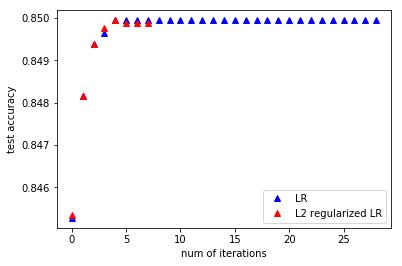

In [76]:
plt.legend()
plt.show()

In [72]:
plt.plot(solver.l2_norms, 'bs', label='LR')
plt.plot(l2_solver.l2_norms, 'rs', label='L2 regularized LR')
plt.xlabel('num of iterations')
plt.ylabel('l2 norm of weights')

Text(0,0.5,'l2 norm of weights')

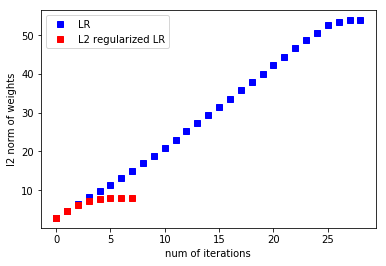

In [73]:
plt.legend()
plt.show()
